In [1]:
%matplotlib inline

#import dependencies
import pandas as pd
import numpy as np
import gmaps
from config import gkey
from matplotlib import pyplot as plt, cm
from ipyleaflet import Map, Heatmap
from ipywidgets import interact

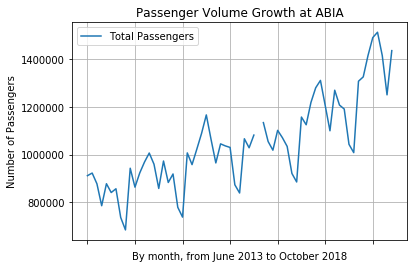

In [2]:
#read in Alan's cleaned up file 
df = pd.read_csv("./resources/data/transformed/AUS_monthly_passengers_clean.csv")

df.plot(x="Month", y="Total Passengers", kind="line", grid=True)
plt.xlabel("By month, from June 2013 to October 2018")
plt.ylabel("Number of Passengers")
plt.title("Passenger Volume Growth at ABIA")
plt.savefig("./resources/images/monthly_passengers.png")
plt.show()

In [3]:
#read in Alan's csv file about inflated adjusted Avg Fares from AUS
df = pd.read_csv('./resources/data/source/AIBA_Average_Airfare_2007_2017.csv')
df

,Year,Average Fare,Inflation Adjusted Avg Fare
0,2007,342.24,413.96
1,2008,338.76,394.60
2,2009,308.11,360.17
3,2010,342.14,393.51
4,2011,367.76,410.02
5,2012,383.05,418.42
6,2013,386.60,416.20
7,2014,393.55,416.92
8,2015,371.99,393.61
9,2016,372.45,389.18


<function matplotlib.pyplot.show(*args, **kw)>

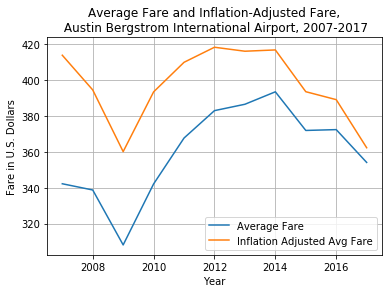

In [4]:
df.plot(x="Year", y=["Average Fare", "Inflation Adjusted Avg Fare"], kind="line", grid=True)
plt.title("Average Fare and Inflation-Adjusted Fare,\n Austin Bergstrom International Airport, 2007-2017")
plt.ylabel("Fare in U.S. Dollars")
plt.savefig("./resources/images/AUS_Inflation_Adjusted_Average_Fares.png")
plt.show

In [5]:
#read Dexter's cleaned up csv files that were created in ./pyDataCleanup.ipynb
df = pd.read_csv('./resources/data/transformed/AUS.csv')
df_coords = pd.read_csv('./resources/data/transformed/destination_airports_lat_lng.csv')

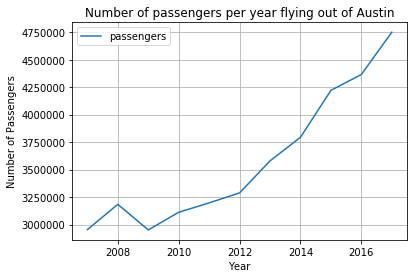

In [6]:
#line chart showcasing the growth of number of passengers per year flying out of Austin
df.groupby('Year').agg({'passengers': 'sum'}).plot(kind='line', grid=True, title='Number of passengers per year flying out of Austin')
plt.ylabel("Number of Passengers")
plt.savefig("./resources/images/AUS_yearly_passenger_growth.png")
plt.show()

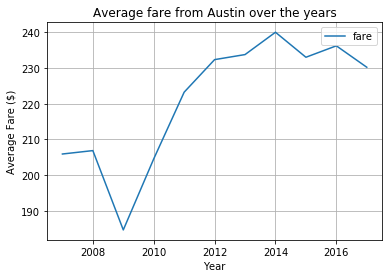

In [7]:
#line chart showcasing the change of average fare over the years
df.groupby('Year').agg({'fare': 'mean'}).plot(kind='line', grid=True, title='Average fare from Austin over the years')
plt.ylabel("Average Fare ($)")
plt.savefig("./resources/images/AUS_yearly_average_fare.png")
plt.show()

In [8]:
def get_dataframe(year):

    #first get the total number of passengers per year and the average fare flying out of Austin to other aiports
    df1 = df[df['Year'] == year].groupby(['Year','airport_2']).agg({'passengers': 'sum', 'fare': 'mean'}).reset_index()

    #now merge aganst the df_coords so that we can get the lat and lng to use in the heatmap
    df_merged = pd.merge(df1, df_coords, how='inner', on=['airport_2', 'airport_2'])
    return df_merged

def show_map(year, map_type='ipyleaflet.HeatMap'):
    df = get_dataframe(year)
    
    #reduce the number of passengers as a representation of 100,000's so that it's easy to use as weights 
    #with a max_intensity of 1.75 for the heatmap
    df['passengers'] = df['passengers'].astype(float) / 100000.0
    
    if map_type == 'ipyleaflet.HeatMap':
        #plot to a map, using Austin, TX as the center
        m = Map(center=[30.267153 ,-97.7430608], zoom=4, dragging=True, inertia=True, scroll_wheel_zoom=True)
        heatmap = Heatmap(locations=df[['lat', 'lng', 'passengers']].values.tolist()
                          , min_opacity=2
                          , radius=15
                          , blur=19
                          , max=1)
        m.add_layer(heatmap);
        return m
    elif map_type == 'gmaps.heatmap_layer':
        gmaps.configure(api_key=gkey)
        # Plot Heatmap
        fig = gmaps.figure()
        
        # Create heat layer
        heat_layer = gmaps.heatmap_layer(locations=df[['lat', 'lng']]
                                         , weights=df['passengers']
                                         , dissipating=False
                                         , max_intensity=1.75
                                         , point_radius=0.2)

        # Add layer
        fig.add_layer(heat_layer)

        # Display figure
        return fig
    

In [9]:
interact(show_map, year=(2007, 2017), map_type=['ipyleaflet.HeatMap', 'gmaps.heatmap_layer'])

interactive(children=(IntSlider(value=2012, description='year', max=2017, min=2007), Dropdown(description='map…

<function __main__.show_map(year, map_type='ipyleaflet.HeatMap')>

In [10]:
def show_scatter(year, passenger_min_value, fare_min_value):
    df = get_dataframe(year)
    
    #reduce to number of passengers as a representation of 1,000's 
    df['passengers'] = df['passengers'].astype(float) / 1000.0    
    
    plt.scatter(x=df['passengers']
                , y=df['fare']
                , s=df['passengers'] 
                , c=np.arange(len(df))
                , cmap=cm.viridis
                , alpha=.75
                , edgecolors='black'
                , linewidths=.75)

    for i, airport_2 in enumerate(df['airport_2']):
        plt.annotate(s=airport_2
                     , xy=(df['passengers'][i], df['fare'][i])
                     , xytext=((df['passengers'][i]) + 12, df['fare'][i] - 3)
                    )
        
    plt.title("Number of passengers v/s average fare per city pair")
    plt.xlabel("Number of passengers in the 1,000's travelling through AUS")
    plt.ylabel(f"Average Fare ($) per year for {year}")
    plt.xlim(passenger_min_value, 600)
    plt.ylim(fare_min_value, 400)
    plt.grid()
    plt.savefig(f"./resources/images/{year}_AUS_passenger_min_value_{passenger_min_value}_average_fare_min_value_{fare_min_value}_scatter.png")
    plt.show()

In [11]:
interact(show_scatter, year=(2007, 2017, 1), passenger_min_value=(0, 300, 25), fare_min_value=(0, 400, 25))

interactive(children=(IntSlider(value=2012, description='year', max=2017, min=2007), IntSlider(value=150, desc…

<function __main__.show_scatter(year, passenger_min_value, fare_min_value)>